In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf

In [51]:
# Path
PATH = '../input/nlp-getting-started/'
PATH_TRAIN = PATH + 'train.csv'
PATH_TEST = PATH + 'test.csv'

# Stop words
STOPWORDS = stopwords.words('english')

# Tokens
TOK_URL = 'url'
TOK_HASH = 'hash'
TOK_LOC = 'loc'
TOK_AT = 'at'
TOK_EMO_POS = 'emop'
TOK_EMO_NEG = 'emon'
TOK_EMPTY = ' '

# Embedding
EMB_SIZE = 32
EMB_EPOCHS = 20
MIN_COUNT = 1
WINDOW = 3

# Learning
MAX_LEN = 20
STR_SHAPE = (MAX_LEN, EMB_SIZE)
BATCH_SIZE = 64
MAX_EPOCHS = 100

# Labels
LABELS = ['No disaster', 'Disaster']

# Filter data

In [89]:
# Load data
df_train = pd.read_csv(PATH_TRAIN)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [90]:
df_test = pd.read_csv(PATH_TEST)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [91]:
# Check entries
print(df_train.shape)
print(df_test.shape)

print('Label values:')
df_train['target'].value_counts(normalize=True)

(7613, 5)
(3263, 4)
Label values:


0    0.57034
1    0.42966
Name: target, dtype: float64

In [92]:
# Drop irrelavent columns
def dropCol(df):
    return df.drop(columns=['id', 'keyword', 'location'], inplace=False)

df_train = dropCol(df_train)
df_test_id = df_test['id'] # Save test id for submission
df_test = dropCol(df_test)
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Lowercase text
def lowercase(df):
    return df.text.str.lower()
    
df_train.text = lowercase(df_train)
df_test_no.text = lowercase(df_test)

df_train.head()

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1


In [8]:
# Show sample sentences
def show_sample_text(num_samples = 3):
    for i in range(num_samples):
        print(df_train['text'][i])
        
show_sample_text()

our deeds are the reason of this #earthquake may allah forgive us all
forest fire near la ronge sask. canada
all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected


In [9]:
# Get words
words = list(df_train.text.str.split(' ', expand=True).stack().unique())

print('Number of words:', len(words))
print('Sample words:', random.choices(words, k=5))

Number of words: 28121
Sample words: ['responders\nhttps://t.co/g1nw99yj8u', 'begun!:', 'citing', 'https://t.co/463p0ys0eb', 'http://t.co/wrqf6u55hh']


In [10]:
# Get words that are not pure letters (tags, html, etc.)
r = re.compile('[a-z]*\W+[a-z]*')
words_special = list(filter(r.match, words))

print('Number of special words:', len(words_special))
print('Sample special words:', random.choices(words_special, k=5))

Number of special words: 15840
Sample special words: ['#flavorchargedtea', 'pakpattan:', "'flip", 'smokes.', '(dis']


In [11]:
def cleanText(df):
    # Replace urls with 'url' token
    text = df_train.text.replace('https?://\S+', TOK_URL, regex=True)

    # Replace hashtags with 'hash' token
    text = text.replace('#\S+', TOK_HASH, regex=True)

    # Replcae @word with 'loc' token
    text = text.replace('@\S+', TOK_LOC, regex=True)

    # Replace @ with 'at' token
    text = text.replace('@', TOK_AT, regex=True)

    # Replace text emojis [:), :-), ;), ;-), :(, :-(, ;(, ;-(] with 'emo-pos' or 'emo-neg' tokens
    text = text.replace('[:;]-?\)', TOK_EMO_POS, regex=True)
    text =text.replace('[:;]-?\(', TOK_EMO_NEG, regex=True)

    # Remove special characters (\n)
    text = text.replace('\\n', TOK_EMPTY, regex=True)

    # Remove signs at the end of words (puctuations etc)
    text = text.replace('[^\w\s]', TOK_EMPTY, regex=True)

    # Filter out anything remaining that is not letters
    text = text.replace('[^a-z]', TOK_EMPTY, regex=True)

    # Stem words and filter out stop words
    ps = PorterStemmer()
    text = text.str.split().apply(lambda words: [ps.stem(word) for word in words if not word in STOPWORDS]).str.join(' ')
    
    return text
    
    
df_train['text_no_special'] = cleanText(df_train)
df_test['text_no_special'] = cleanText(df_test)

In [12]:
# Get words
words = list(df_train.text_no_special.str.split(' ', expand=True).stack().unique())

print('Number of words:', len(words))
print('Sample words:', random.choices(words, k=10))

Number of words: 9837
Sample words: ['worseit', 'lich', 'obstacl', 'lift', 'pleas', 'voslooru', 'windsor', 'homi', 'syd', 'militia']


In [13]:
# Get words that are not pure letters (sanity check - should be 0)
r = re.compile('[a-z]*\W+[a-z]*')
words_special = list(filter(r.match, words))

print('Number of special words:', len(words_special))
if len(words_special) > 0:
    print('Sample special words:', random.choices(words_special, k=5))

Number of special words: 0


In [14]:
# Check word frequency
freq = df_train.text_no_special.str.split() \
    .apply(lambda w: pd.value_counts(w)) \
    .sum(axis = 0) \
    .sort_values(ascending=False)

freq

url        4720.0
hash       3367.0
loc        2710.0
like        410.0
fire        357.0
            ...  
arrog         1.0
doom          1.0
planner       1.0
decre         1.0
symptom       1.0
Length: 9837, dtype: float64

In [15]:
# Get words with low frequency - arbitrarily: less than 10
low_freq = freq[freq < 10]
words_low_freq = list(low_freq.index)

print(len(freq)) # All words
print(len(words_low_freq)) # Frequent words

9837
8514


In [16]:
# Add \b before and after each word to match exact word using regex
words_low_freq_exact = [r'\b' + w + r'\b' for w in words_low_freq]

In [17]:
# Remove words with low frequency
df_train['text_filtered'] = df_train.text_no_special.replace(words_low_freq_exact, '', regex=True)
df_test['text_filtered'] = df_test.text_no_special.replace(words_low_freq_exact, '', regex=True)

In [18]:
# Remove multiple spaces
df_train['text_filtered'] = df_train['text_filtered'].replace(' +', ' ', regex=True)
df_test['text_filtered'] = df_test['text_filtered'].replace(' +', ' ', regex=True)

In [19]:
# Check current word frequency
high_freq = df_train.text_filtered.str.split() \
    .apply(lambda w: pd.value_counts(w)) \
    .sum(axis = 0) \
    .sort_values(ascending=False)

high_freq

url       4720.0
hash      3367.0
loc       2710.0
like       410.0
fire       357.0
           ...  
da          10.0
aw          10.0
unlock      10.0
ep          10.0
organ       10.0
Length: 1323, dtype: float64

# Explore data

In [20]:
# Build statistics
dist = pd.DataFrame()
dist['target'] = df_train.target

dist['char_count'] = df_train.text_filtered.str.len() # Number of characters
dist['word_count'] = df_train.text_filtered.str.split().apply(len) # Number of words
dist['avg_word_len'] = df_train.text_filtered.str.split().apply(lambda x: np.mean([len(w) for w in x])) # average word length

dist['url_count'] = df_train.text_filtered.str.count(r'\b'+TOK_URL+r'\b') # Number of links
dist['hash_count'] = df_train.text_filtered.str.count(r'\b'+TOK_HASH+r'\b') # Number of has-tags
dist['loc_count'] = df_train.text_filtered.str.count(r'\b'+TOK_LOC+r'\b') # Number of locations
dist['at_count'] = df_train.text_filtered.str.count(TOK_AT) # number of references (at)

# Number of emoticons
dist['emo_pos_count'] = df_train.text_filtered.str.count(TOK_EMO_POS) # Positive emoticons
dist['emo_neg_count'] = df_train.text_filtered.str.count(TOK_EMO_NEG) # Negative emoticons

dist.head()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,target,char_count,word_count,avg_word_len,url_count,hash_count,loc_count,at_count,emo_pos_count,emo_neg_count
0,1,19,4,3.750000,0,1,0,0,0,0
1,1,26,5,4.400000,0,0,0,0,0,0
2,1,41,7,4.857143,0,0,0,0,0,0
3,1,33,5,5.800000,0,1,0,0,0,0
4,1,37,7,4.428571,0,2,0,0,0,0


[Text(81.125, 0.5, '')]

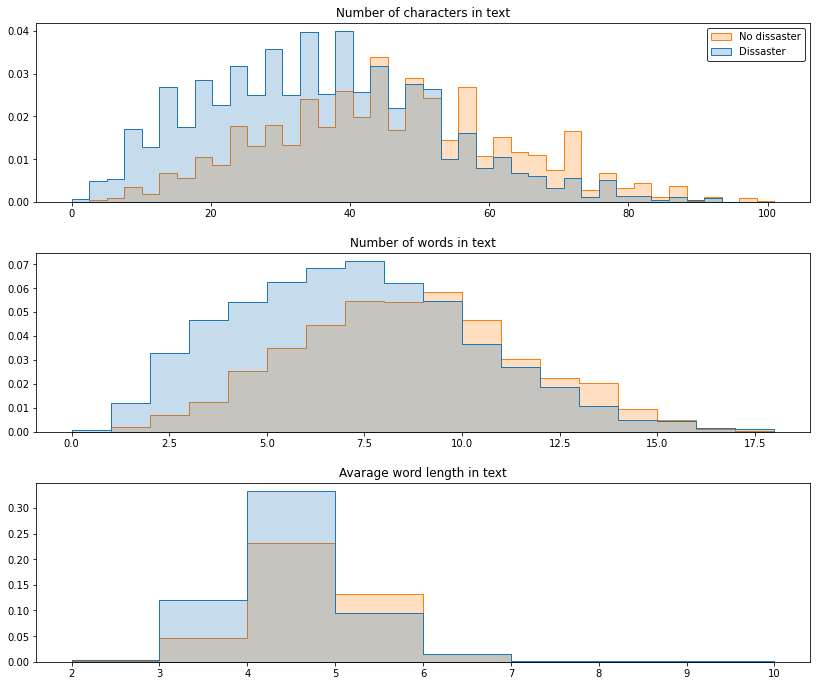

In [21]:
# Setup figure
fig, axes = plt.subplots(3, 1, figsize=(12,10))
fig.tight_layout(pad=3.0)

# Number of characters in sentence by category
ax = plt.subplot(3, 1, 1)
sns.histplot(dist, x='char_count', hue='target', element='step', ax=ax, legend=False, stat='probability')
plt.title('Number of characters in text')
ax.legend(['No dissaster', 'Dissaster'], facecolor='white', edgecolor='black')
ax.set(xlabel=None)
ax.set(ylabel=None)

# Number of words in sentence by category
ax = plt.subplot(3, 1, 2)
sns.histplot(dist, x='word_count', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Number of words in text')
ax.set(xlabel=None)
ax.set(ylabel=None)

# Avarage word length by category
ax = plt.subplot(3, 1, 3)
sns.histplot(dist, x='avg_word_len', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Avarage word length in text')
ax.set(xlabel=None)
ax.set(ylabel=None)

[Text(446.36136363636354, 0.5, '')]

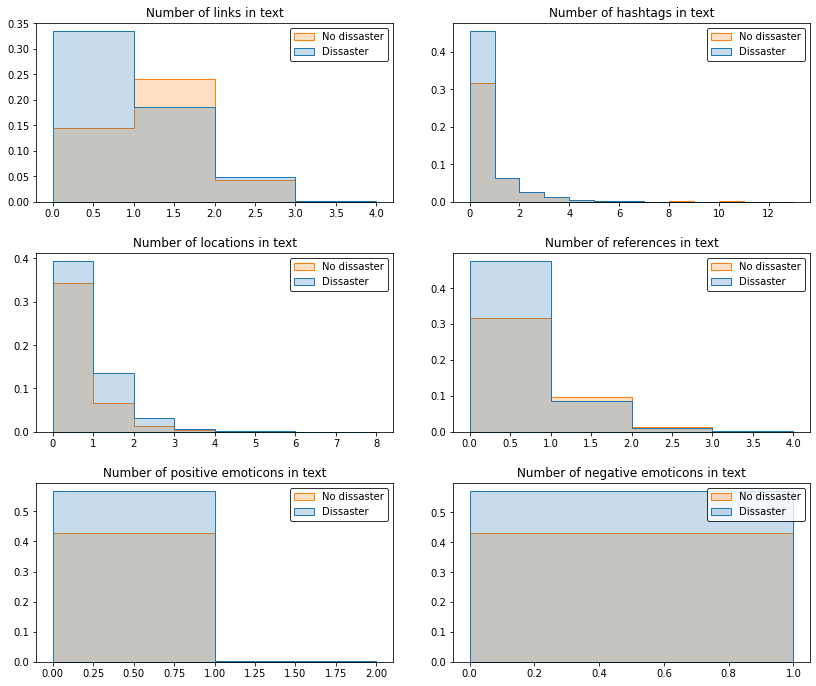

In [22]:
# Setup figure
fig, axes = plt.subplots(3, 2, figsize=(12,10))
fig.tight_layout(pad=3.0)

# Number of links in sentence by category
ax = plt.subplot(3, 2, 1)
sns.histplot(dist, x='url_count', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Number of links in text')
ax.legend(['No dissaster', 'Dissaster'], facecolor='white', edgecolor='black')
ax.set(xlabel=None)
ax.set(ylabel=None)

# Number of hashtags in sentence by category
ax = plt.subplot(3, 2, 2)
sns.histplot(dist, x='hash_count', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Number of hashtags in text')
ax.legend(['No dissaster', 'Dissaster'], facecolor='white', edgecolor='black')
ax.set(xlabel=None)
ax.set(ylabel=None)

# Number of locations in sentence by category
ax = plt.subplot(3, 2, 3)
sns.histplot(dist, x='loc_count', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Number of locations in text')
ax.legend(['No dissaster', 'Dissaster'], facecolor='white', edgecolor='black')
ax.set(xlabel=None)
ax.set(ylabel=None)

# Number of references in sentence by category
ax = plt.subplot(3, 2, 4)
sns.histplot(dist, x='at_count', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Number of references in text')
ax.legend(['No dissaster', 'Dissaster'], facecolor='white', edgecolor='black')
ax.set(xlabel=None)
ax.set(ylabel=None)

# Number of positive emoticons by category
ax = plt.subplot(3, 2, 5)
sns.histplot(dist, x='emo_pos_count', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Number of positive emoticons in text')
ax.legend(['No dissaster', 'Dissaster'], facecolor='white', edgecolor='black')
ax.set(xlabel=None)
ax.set(ylabel=None)

# Number of negative emoticons in sentence by category
ax = plt.subplot(3, 2, 6)
sns.histplot(dist, x='emo_neg_count', hue='target', element='step', binwidth=1, ax=ax, legend=False, stat='probability')
plt.title('Number of negative emoticons in text')
ax.legend(['No dissaster', 'Dissaster'], facecolor='white', edgecolor='black')
ax.set(xlabel=None)
ax.set(ylabel=None)

In [23]:
# More statistics
dist2 = pd.DataFrame()

# Number of sentences with links
dist2['url'] = [dist['url_count'][dist['target'] == 0].sum(), dist['url_count'][dist['target'] == 1].sum()] / dist['url_count'].sum()

# Number of sentences with has-tags
dist2['hash'] = [dist['hash_count'][dist['target'] == 0].sum(), dist['hash_count'][dist['target'] == 1].sum()] / dist['hash_count'].sum()

# Number sentences with locations
dist2['loc'] = [dist['loc_count'][dist['target'] == 0].sum(), dist['loc_count'][dist['target'] == 1].sum()] / dist['loc_count'].sum()

# number sentences with of refferences (at)
dist2['at'] = [dist['at_count'][dist['target'] == 0].sum(), dist['at_count'][dist['target'] == 1].sum()] / dist['at_count'].sum()

# Number sentences with of emoticons
dist2['emo_pos'] = [dist['emo_pos_count'][dist['target'] == 0].sum(), dist['emo_pos_count'][dist['target'] == 1].sum()] / dist['emo_pos_count'].sum()
dist2['emo_neg'] = [dist['emo_neg_count'][dist['target'] == 0].sum(), dist['emo_neg_count'][dist['target'] == 1].sum()] / dist['emo_neg_count'].sum()

dist2

,url,hash,loc,at,emo_pos,emo_neg
0,0.466737,0.499257,0.671956,0.453073,0.878788,0.785714
1,0.533263,0.500743,0.328044,0.546927,0.121212,0.214286


Text(0.5, 1.0, 'Sentences with emoticons (negative) %')

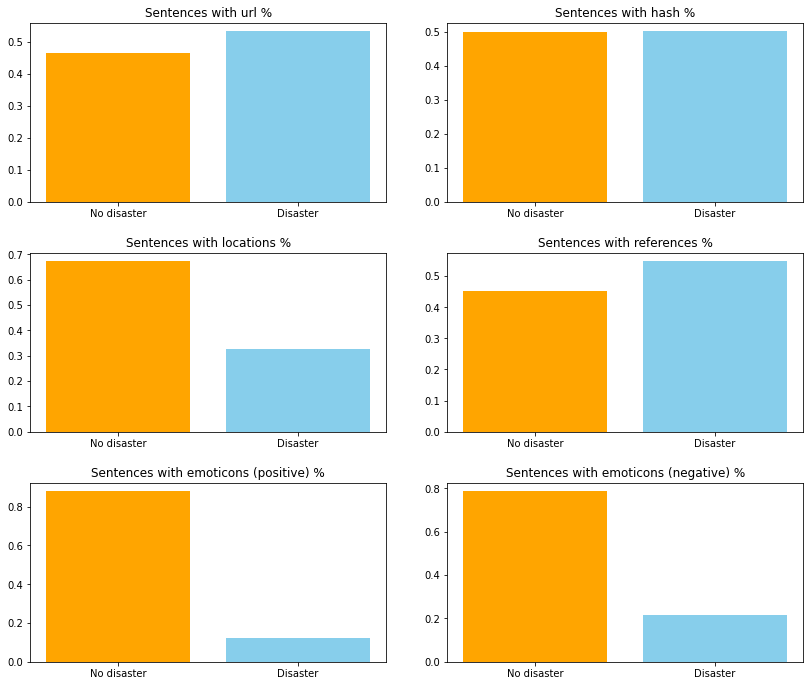

In [24]:
# Setup figure
fig, axes = plt.subplots(3, 2, figsize=(12,10))
fig.tight_layout(pad=3.0)

# Number of sentences with links
ax = plt.subplot(3, 2, 1)
plt.bar(LABELS, dist2['url'], color=['orange', 'skyblue'])
plt.title('Sentences with url %')

# Number of sentences with hash-tags
ax = plt.subplot(3, 2, 2)
plt.bar(LABELS, dist2['hash'], color=['orange', 'skyblue'])
plt.title('Sentences with hash %')

# Number of sentences with locations
ax = plt.subplot(3, 2, 3)
plt.bar(LABELS, dist2['loc'], color=['orange', 'skyblue'])
plt.title('Sentences with locations %')

# Number of sentences with references
ax = plt.subplot(3, 2, 4)
plt.bar(LABELS, dist2['at'], color=['orange', 'skyblue'])
plt.title('Sentences with references %')

# Number of sentences with emoticons (positive)
ax = plt.subplot(3, 2, 5)
plt.bar(LABELS, dist2['emo_pos'], color=['orange', 'skyblue'])
plt.title('Sentences with emoticons (positive) %')

# Number of sentences with emoticons (negative)
ax = plt.subplot(3, 2, 6)
plt.bar(LABELS, dist2['emo_neg'], color=['orange', 'skyblue'])
plt.title('Sentences with emoticons (negative) %')

# Embedding

In [25]:
# Word2Vec
sentences = list(df_train.text_filtered.str.split())
w2v_model = Word2Vec(sentences, vector_size=EMB_SIZE, min_count=MIN_COUNT, window=WINDOW)

In [26]:
w2v_model.train(sentences, total_examples=len(sentences), epochs=EMB_EPOCHS) # Train word2vec

(912224, 1119800)

In [27]:
print('loc = ',w2v_model.wv['loc'])
print('organ =', w2v_model.wv['organ'])

loc =  [ 0.24135232 -0.83551437  0.14181854  0.7799861   0.20203306  0.21062197
  0.86415863  0.61904734 -0.06432422 -1.1618714   0.8452577  -0.749076
  0.45707425  0.00428803 -0.6188569  -0.9954692   0.03030875  0.46208677
  0.79692227  0.9709526   0.70159703  0.229056    0.6028506  -0.7904826
 -0.6893283  -0.15195483  0.29424116  0.67034215 -0.7194424   0.23064142
 -0.7537574   0.69653594]
organ = [ 0.11422801 -0.16782749 -0.03936543  0.12294938  0.3124397  -0.12984528
  0.05596136 -0.19751339 -0.06811431 -0.05329242  0.12451038 -0.44305733
  0.1910116  -0.19945146  0.02233859  0.04195733 -0.13069348  0.07504404
 -0.14499122  0.21598566  0.2829279   0.57486814  0.04280146 -0.25698352
 -0.1427086  -0.13597484 -0.6789857   0.41354218 -0.16458265 -0.1648514
 -0.09305888  0.06461465]


In [28]:
# Vectorize sentences
df_X = df_train.text_filtered.str.split().apply(lambda x: [w2v_model.wv[w] for w in x])
df_X_test = df_test.text_filtered.str.split().apply(lambda x: [w2v_model.wv[w] for w in x])

df_X.head()

0    [[0.52887547, -0.4058926, 0.4893748, 0.5657491...
1    [[-0.66776824, -0.97429913, -0.18394032, 1.152...
2    [[-0.5227094, -0.6154677, 0.09178477, -0.08280...
3    [[-1.2136906, -0.3834997, -0.2243241, -0.58504...
4    [[-0.54911387, -0.027411642, 0.10739737, 1.402...
Name: text_filtered, dtype: object

In [29]:
df_X.shape

(7613,)

# Prepare data

In [64]:
# Convert data to numpy
X = np.asarray([np.asarray([word for word in sentence]) for sentence in df_X])
X_test = np.asarray([np.asarray([word for word in sentence]) for sentence in df_X_test])

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [65]:
# Get max sentece length (for constant)
np.max([len(words) for words in df_X]) # 18

18

In [66]:
# Create numpy array for data with padding (padding token = 0)
X = np.zeros((len(df_X), STR_SHAPE[0], STR_SHAPE[1])) # samples, sentence legth, word length
for i in range(len(df_X)):
    for j in range(len(df_X[i])):
        for k in range(len(df_X[i][j])):
            X[i, j, k] = df_X[i][j][k]
            
X_test = np.zeros((len(df_X_test), STR_SHAPE[0], STR_SHAPE[1])) # samples, sentence legth, word length
for i in range(len(df_X_test)):
    for j in range(len(df_X_test[i])):
        for k in range(len(df_X_test[i][j])):
            X[i, j, k] = df_X_test[i][j][k]
            
            
Y = np.array([target for target in df_train.target])
            
print(X.shape)
print(Y.shape)

(7613, 20, 32)
(7613,)


In [67]:
# Split data to train and validation
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(6090, 20, 32)
(1523, 20, 32)
(6090,)
(1523,)


# Model - random forest

In [68]:
# Ranfom forest classifier
model1 = RandomForestClassifier()

In [69]:
# Reduce data for training
X_red = np.mean(X, axis=1)
X_train_red = np.mean(X_train, axis=1)
X_val_red = np.mean(X_val, axis=1)

print(X_red.shape)
print(X_train_red.shape)
print(X_val_red.shape)

(7613, 32)
(6090, 32)
(1523, 32)


In [70]:
# Fit data
model1.fit(X_train_red, y_train)

RandomForestClassifier()

In [72]:
# Evaluate
y_all_pred = model1.predict(X_red)
y_train_pred = model1.predict(X_train_red)
y_val_pred = model1.predict(X_val_red)

print('Training accuracy:', accuracy_score(y_train, y_train_pred))
print('Validation accuracy:', accuracy_score(y_val, y_val_pred))
print('Overall accuracy:', accuracy_score(y_all_pred, Y))

Training accuracy: 0.983743842364532
Validation accuracy: 0.7846355876559422
Overall accuracy: 0.9439117299356364


# Model - lstm


In [73]:
# Create model
def createModel():
    inputs = tf.keras.Input(shape=STR_SHAPE)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(inputs)
    x = tf.keras.layers.GlobalAvgPool1D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model_lstm = createModel()

In [74]:
# Compile model
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

In [75]:
# Create early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

In [76]:
# Train model
history = model_lstm.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               batch_size=BATCH_SIZE,
               epochs=MAX_EPOCHS,
               callbacks=[early_stop])

Epoch 1/100
96/96 [==============================] - 12s 79ms/step - loss: 0.6810 - accuracy: 0.6024 - val_loss: 0.6612 - val_accuracy: 0.7702
Epoch 2/100
96/96 [==============================] - 7s 78ms/step - loss: 0.5677 - accuracy: 0.7140 - val_loss: 0.6293 - val_accuracy: 0.7833
Epoch 3/100
96/96 [==============================] - 7s 75ms/step - loss: 0.5381 - accuracy: 0.7398 - val_loss: 0.5906 - val_accuracy: 0.7859
Epoch 4/100
96/96 [==============================] - 7s 74ms/step - loss: 0.5232 - accuracy: 0.7422 - val_loss: 0.5431 - val_accuracy: 0.7919
Epoch 5/100
96/96 [==============================] - 7s 75ms/step - loss: 0.5327 - accuracy: 0.7445 - val_loss: 0.5012 - val_accuracy: 0.8011
Epoch 6/100
96/96 [==============================] - 7s 76ms/step - loss: 0.5245 - accuracy: 0.7492 - val_loss: 0.4739 - val_accuracy: 0.8024
Epoch 7/100
96/96 [==============================] - 7s 77ms/step - loss: 0.5135 - accuracy: 0.7451 - val_loss: 0.4559 - val_accuracy: 0.8004
Epoch

In [81]:
# Accuracy
print('Training accuracy:', model_lstm.evaluate(X_train, y_train))
print('Validation accuracy:', model_lstm.evaluate(X_val, y_val))
print('Overall accuracy:', model_lstm.evaluate(X, Y))

191/191 [==============================] - 2s 8ms/step - loss: 0.4334 - accuracy: 0.8038
Training accuracy: [0.43341299891471863, 0.8037766814231873]
48/48 [==============================] - 0s 7ms/step - loss: 0.4384 - accuracy: 0.8063
Validation accuracy: [0.4384206235408783, 0.8063033223152161]
238/238 [==============================] - 2s 7ms/step - loss: 0.4344 - accuracy: 0.8043
Overall accuracy: [0.43441465497016907, 0.8042821288108826]


In [82]:
# Plot accuracy and loss metrics
def plotMetrics(history, epoch_start = 0):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range[2:], acc[2:], label='Training Accuracy')
    plt.plot(epochs_range[2:], val_acc[2:], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range[2:], loss[2:], label='Training Loss')
    plt.plot(epochs_range[2:], val_loss[2:], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

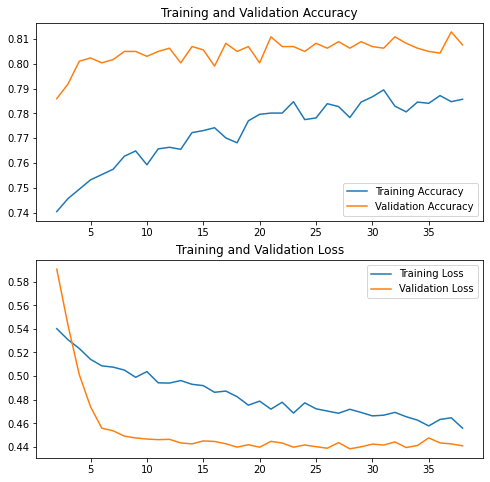

In [83]:
plotMetrics(history)

# Create submission

In [93]:
# Predict test set
y_test_pred = model_lstm.predict(X_test)
y_test_pred_formatted = [1 if y > 0.5 else 0 for y in y_test_pred]

# Build submission dataframe
submission = pd.DataFrame({'id': df_test_id, 'target': y_test_pred_formatted})
print(len(submission))
submission.head()

3263


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [94]:
# Save submission to disk
submission.to_csv('submission.csv',index=False)